<a href="https://colab.research.google.com/github/bayuzen19/Business-Inteligence-Batch-3/blob/main/Time_Series_Advance_Tugas_Day_12_Bayuzen_Ahmad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install sktime[all_extras]

In [2]:
# utilities packages
import datetime
import os

# data wrangling and transformation package
import numpy as np
import pandas as pd
import statsmodels.api as sm

# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# time series modeling
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
# load sktime for time series forecasting

from sktime.utils.plotting import plot_series # from plotting
from sktime.forecasting.naive import NaiveForecaster # for naive forecasting
from sktime.forecasting.arima import AutoARIMA # for automated ARIMA forecasting
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # for exponential smoothing forecasting
from sktime.forecasting.ets import AutoETS # for automated ETS forecasting 
from sktime.forecasting.tbats import TBATS # for TBATS forecasting
from sktime.forecasting.fbprophet import Prophet # for Prophet forecasting
from sktime.forecasting.base import ForecastingHorizon # for creating forecast horizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split, 
    ExpandingWindowSplitter, 
    SlidingWindowSplitter
) # for train-test split and cross validation
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error
) # for evaluation metrics
from sktime.forecasting.model_evaluation import evaluate # for evaluating CV results

%matplotlib inline
import warnings
sns.set_style("ticks")
sns.set(font_scale = 1.5)

#==============================================================================

Time Series Forecasting - Advanced 60 poin <br>

Divisi bisnis dari tribe Growth meminta anda untuk melakukan analisis terhadap transaksi yang terjadi di platform e-commerce secara harian dan anda juga diminta untuk melakukan forecasting yang mana hasil dari peramalan tersebut akan digunakan untuk menyusun strategi kedepannya. Berikut metadata dari data yang akan dianalisis: <br>
'Row ID' - This is nothing but Serial No. <br>
'Order ID' - ID created when a product order is placed. <br>
'Order Date' - Date on which a customer places his/her order. <br>
'Ship Date' - Date on which the order is shipped. <br>
'Ship Mode' - Mode of shipment of each order. <br>
'Customer ID' - ID assigned to each customer who places an order. <br>
'Customer Name' - Name of Customer. <br>
'Segment' - Section from where the order is placed. <br>
'Country' - Country details of this data set. We are looking only for US store data. <br>
'City' - Cities of US are listed here. <br>
'State' - States of US are listed here. <br>
'Postal Code' - pin code <br>
'Region' - grouped into region wise <br>
'Product ID' - Product ID of each product <br>
'Category' - Category to which each product belongs to. <br>
'Sub-Category' - Sub-Category of each Category <br>
'Product Name' - Name of products. <br>
'Sales' - Selling Price of each product. <br>
'Quantity' - number of quantity available for a particular product. <br>
'Discount' - Discount available on each product. <br>
'Profit' - Profit gained on each product. <br>

Hitunglah jumlah pembeli, jumlah transaksi, GMV, dan profit yang diperoleh dengan rentang waktu berikut: (poin 5) <br>
Harian <br>
Mingguan <br>
Bulanan <br>
Catatan: GMV dihitung berdasarkan total spending yang dilakukan customer dengan memperhitungkan semua biaya dan diskon yang dibayarkan customer <br>
Hitunglah monthly retention dari kegiatan transaksi yang terjadi di dalam platform e-commerce. (Poin 10) <br>
Catatan: Monthly retention dihitung berdasarkan jumlah customer yang kembali berbelanja setelah sebelumnya juga berbelanja di bulan sebelumnya <br>
Identifikasi produk-produk apa saja yang membawa profit terbesar dalam 3 bulan terakhir (Poin 5) <br>

Buatlah model forecasting menggunakan model yang sudah diajarkan pada materi day 12 untuk memprediksi jumlah visitor dan jumlah transaksi untuk 1 bulan kedepan dengan data harian. Anda diharuskan setidaknya membuat 2 model untuk selanjutnya diambil model terbaik berdasarkan MAPE terkecil. Berikan rekomendasi apa yang perlu dilakukan tim bisnis berdasarkan hasil forecasting dan analisis anda. (Poin 30)

Catatan: Perhatikan baik-baik data yang dianalisis, karena jika tidak anda bisa menghitung metrik bisnis dengan cara yang salah.


In [3]:
pd.set_option("max_columns",None)
pd.set_option("max_rows",None)
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/time_series_data/superstore_time_series_dataset/superstore_train.csv", parse_dates=['Order Date'],)

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df[df["Order Date"]=='2017-12-12T00:00:00.000000000']

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit


In [6]:
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         8000 non-null   int64         
 1   Order ID       8000 non-null   object        
 2   Order Date     8000 non-null   datetime64[ns]
 3   Ship Date      8000 non-null   object        
 4   Ship Mode      8000 non-null   object        
 5   Customer ID    8000 non-null   object        
 6   Customer Name  8000 non-null   object        
 7   Segment        8000 non-null   object        
 8   Country        8000 non-null   object        
 9   City           8000 non-null   object        
 10  State          8000 non-null   object        
 11  Postal Code    8000 non-null   int64         
 12  Region         8000 non-null   object        
 13  Product ID     8000 non-null   object        
 14  Category       8000 non-null   object        
 15  Sub-Category   8000 n

In [9]:
#convert to date time
df["Order Date"] = pd.to_datetime(df["Order Date"],format="%Y-%m-%d")
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         8000 non-null   int64         
 1   Order ID       8000 non-null   object        
 2   Order Date     8000 non-null   datetime64[ns]
 3   Ship Date      8000 non-null   datetime64[ns]
 4   Ship Mode      8000 non-null   object        
 5   Customer ID    8000 non-null   object        
 6   Customer Name  8000 non-null   object        
 7   Segment        8000 non-null   object        
 8   Country        8000 non-null   object        
 9   City           8000 non-null   object        
 10  State          8000 non-null   object        
 11  Postal Code    8000 non-null   int64         
 12  Region         8000 non-null   object        
 13  Product ID     8000 non-null   object        
 14  Category       8000 non-null   object        
 15  Sub-Category   8000 n

In [11]:
for x in df.columns:
  print(f"Unik dari {x}")
  print(f"{df[x].unique()}")
  print()

Unik dari Row ID
[   1    2    3 ... 7998 7999 8000]

Unik dari Order ID
['CA-2016-152156' 'CA-2016-138688' 'US-2015-108966' ... 'US-2015-165743'
 'US-2017-105998' 'US-2014-148194']

Unik dari Order Date
['2016-11-08T00:00:00.000000000' '2016-06-12T00:00:00.000000000'
 '2015-10-11T00:00:00.000000000' ... '2014-05-31T00:00:00.000000000'
 '2014-01-03T00:00:00.000000000' '2016-07-20T00:00:00.000000000']

Unik dari Ship Date
['2016-11-11T00:00:00.000000000' '2016-06-16T00:00:00.000000000'
 '2015-10-18T00:00:00.000000000' ... '2017-07-30T00:00:00.000000000'
 '2016-04-30T00:00:00.000000000' '2014-05-07T00:00:00.000000000']

Unik dari Ship Mode
['Second Class' 'Standard Class' 'First Class' 'Same Day']

Unik dari Customer ID
['CG-12520' 'DV-13045' 'SO-20335' 'BH-11710' 'AA-10480' 'IM-15070'
 'HP-14815' 'PK-19075' 'AG-10270' 'ZD-21925' 'KB-16585' 'SF-20065'
 'EB-13870' 'EH-13945' 'TB-21520' 'MA-17560' 'GH-14485' 'SN-20710'
 'LC-16930' 'RA-19885' 'ES-14080' 'ON-18715' 'PO-18865' 'LH-16900'
 'DP

In [12]:
df['GMV'] = df["Quantity"]*(df["Sales"] - df["Discount"]*df['Sales'])

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,GMV
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,523.920000
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2195.820000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,29.240000
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2633.338125
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,35.788800


In [13]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,GMV
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,523.920000
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2195.820000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,29.240000
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2633.338125
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,35.788800


# Advance No 1

## Jumlah Customer

In [14]:
#untuk bulanan
df["months"] = df["Order Date"].dt.month

#untuk harian
df["days"] = df['Order Date'].dt.day

#untuk mingguan
df["weekdays"] = [x.strftime('%A') for x in df["Order Date"]]

In [15]:
df["weekdays"].unique()

array(['Tuesday', 'Sunday', 'Monday', 'Saturday', 'Wednesday', 'Friday',
       'Thursday'], dtype=object)

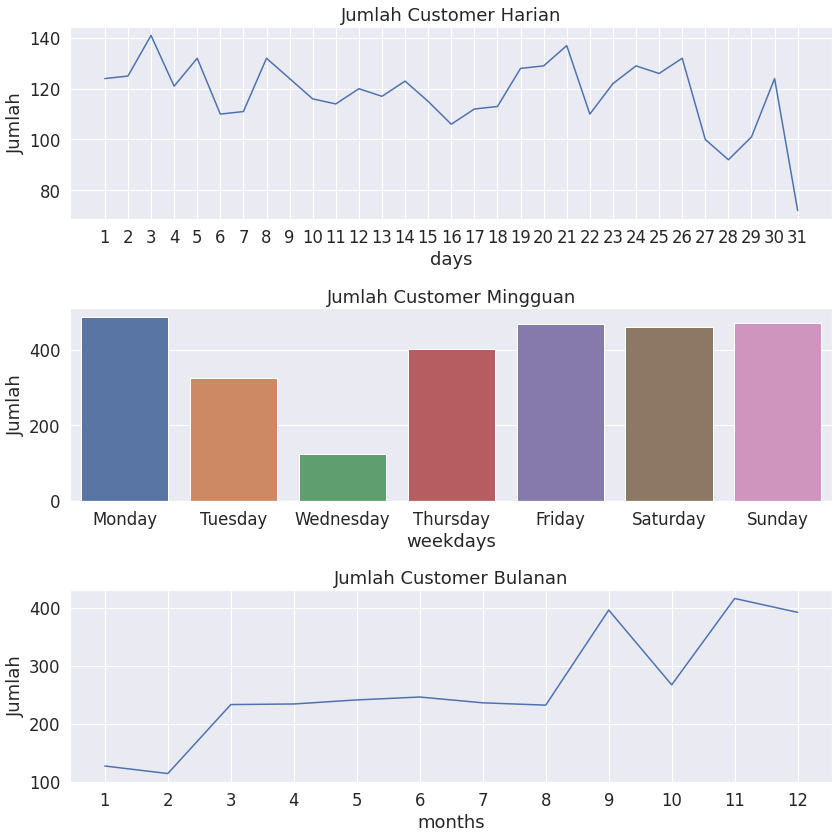

In [16]:
#dayli 
customer_dayli = df.groupby("days",as_index=False).agg({"Customer ID":lambda x: x.nunique()})

#mingguan
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
customer_weekdays = df.groupby("weekdays",as_index=False).agg({"Customer ID":lambda x: x.nunique()})

#bulanan
customer_months = df.groupby("months",as_index=False).agg({"Customer ID":lambda x: x.nunique()})


#visualisasi
plt.figure(figsize=(12,12))
plt.subplot(311)
sns.lineplot(data=customer_dayli,x="days",y="Customer ID").set_title("Jumlah Customer Harian")
plt.xticks([i for i in np.arange(1,32)])
plt.ylabel("Jumlah")

plt.subplot(312)
sns.barplot(data=customer_weekdays,x="weekdays",y="Customer ID",order=order).set_title("Jumlah Customer Mingguan")
plt.ylabel("Jumlah")

plt.subplot(313)
sns.lineplot(data=customer_months,x="months",y="Customer ID").set_title("Jumlah Customer Bulanan")
plt.xticks([i for i in np.arange(1,13)])
plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

1.jumlah customerdatang berkunjung memiliki trend menurun hingga 2 minggu kedepan, selanjutnya mengalami peningkatan hingga ditanggal 21 dan selanjutnya mengalami penurunan kembali, kemungkinan type customer adalah customer yang berbelanja kebutuhan selama 2 minggu pemakaian <br>
2.senin jumat sabtu dan minggu adalah hari dimana customer banyak berkunjung <br>
3.trend peningkatan customer datang berkunjung berada dibulan 8-11

## Jumlah Transaction

In [17]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit', 'GMV',
       'months', 'days', 'weekdays'],
      dtype='object')

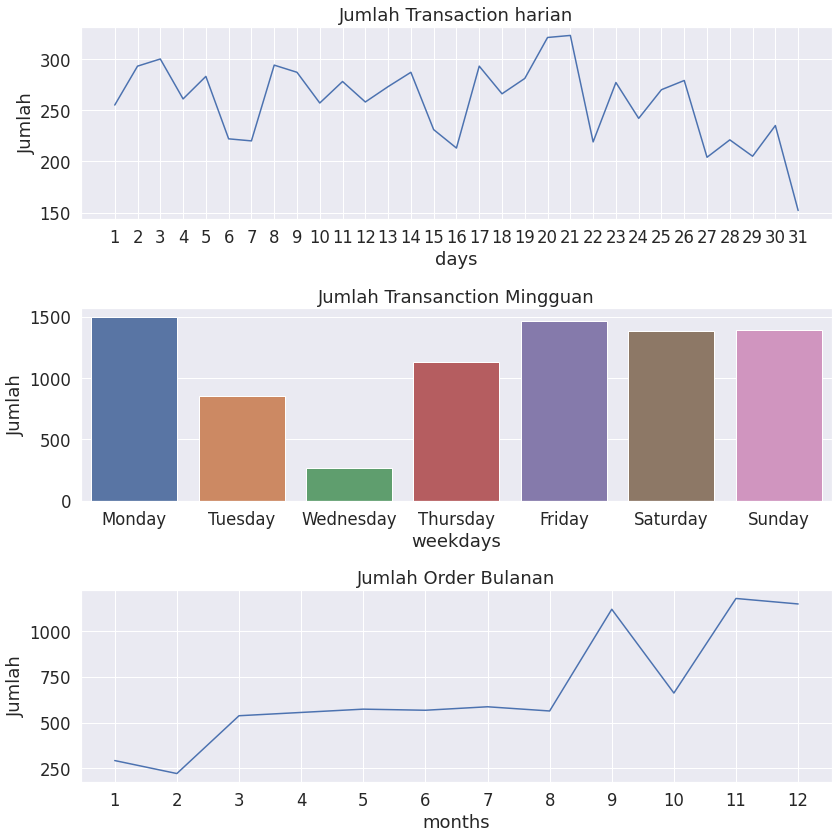

In [18]:
#dayli 
trx_dayli = df.groupby("days",as_index=False)["Order ID"].size()

#mingguan
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trx_weekdays = df.groupby("weekdays",as_index=False)["Order ID"].size()

#bulanan
trx_months = df.groupby("months",as_index=False)["Order ID"].size()


#visualisasi
plt.figure(figsize=(12,12))
plt.subplot(311)
sns.lineplot(data=trx_dayli,x="days",y="size").set_title("Jumlah Transaction harian")
plt.xticks([i for i in np.arange(1,32)])
plt.ylabel("Jumlah")

plt.subplot(312)
sns.barplot(data=trx_weekdays,x="weekdays",y="size",order=order).set_title("Jumlah Transanction Mingguan")
plt.ylabel("Jumlah")

plt.subplot(313)
sns.lineplot(data=trx_months,x="months",y="size").set_title("Jumlah Order Bulanan")
plt.xticks([i for i in np.arange(1,13)])
plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

Observasi : <br>
1.Jumlah Transaksi (distinct) harian terdapat pola pada tangal 1-3 jumlah customer banyak yang berkunjung, kemudian berkurang pada tanggal 3 hingga 7, dan meningkat kembali di tanggal 8 dan konsisten hingga tanggal 14 dan mengalami penurunan kembali pada tanggal 15 dan 16 kemudian meningkat kembali di 17 hingga 21 dan mengalami tren turun hingga akhir bulan. <br>
2.Jumlah Transaksi yang banyak pada hari senin,jumat,sabtu dan minggu. <br>
3.ada pola peningkatan trend pada bulan 8 hingga 12 atau pada akhir tahun. <br>

## GMV

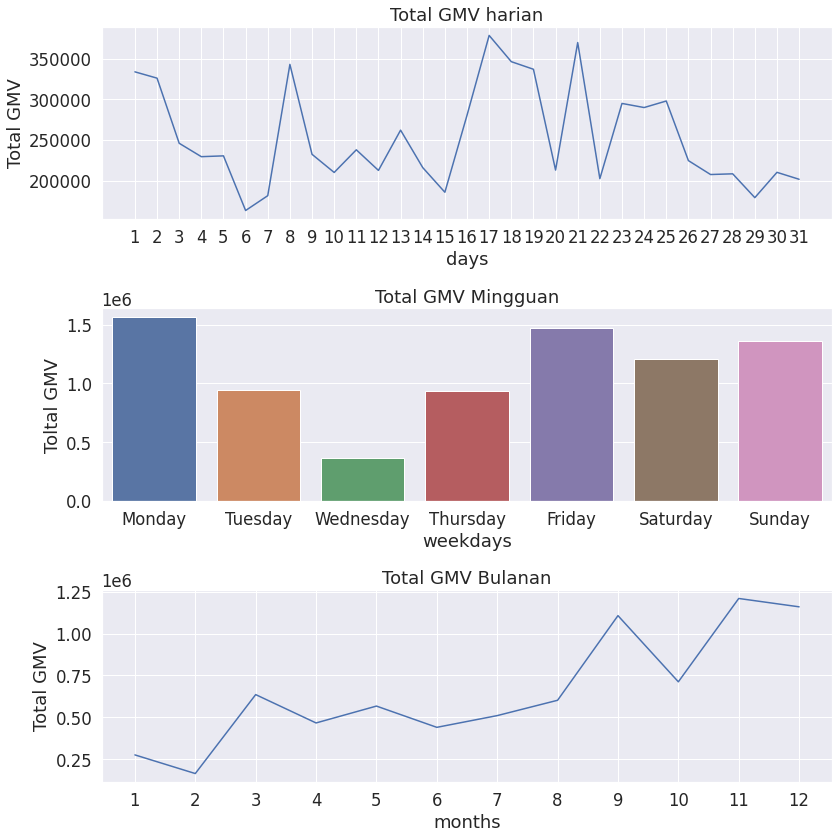

In [19]:
#dayli 
gmv_dayli = df.groupby("days",as_index=False)["GMV"].sum()

#mingguan
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
gmv_weekdays = df.groupby("weekdays",as_index=False)["GMV"].sum()

#bulanan
gmv_months = df.groupby("months",as_index=False)["GMV"].sum()


#visualisasi
plt.figure(figsize=(12,12))
plt.subplot(311)
sns.lineplot(data=gmv_dayli,x="days",y="GMV").set_title("Total GMV harian")
plt.xticks([i for i in np.arange(1,32)])
plt.ylabel("Total GMV")

plt.subplot(312)
sns.barplot(data=gmv_weekdays,x="weekdays",y="GMV",order=order).set_title("Total GMV Mingguan")
plt.ylabel("Toltal GMV")

plt.subplot(313)
sns.lineplot(data=gmv_months,x="months",y="GMV").set_title("Total GMV Bulanan")
plt.xticks([i for i in np.arange(1,13)])
plt.ylabel("Total GMV")

plt.tight_layout()
plt.show()

Observasi : <br>
1.Jumlah GMV harian terlihat adanya trend turun di tanggal 1 hingga 6, kemudian naik di tanggal 7 dan terlihat relative konstan hingga tanggal 22 dan mengalami tren trun kembali setelah tanggal 22. <br>
2.Jumlah GMV yang banyak pada hari senin,jumat,sabtu dan minggu. <br>
3.adanya trend peningkatan bulanan pada GMV dari buan 3 hingga 11

## Profit

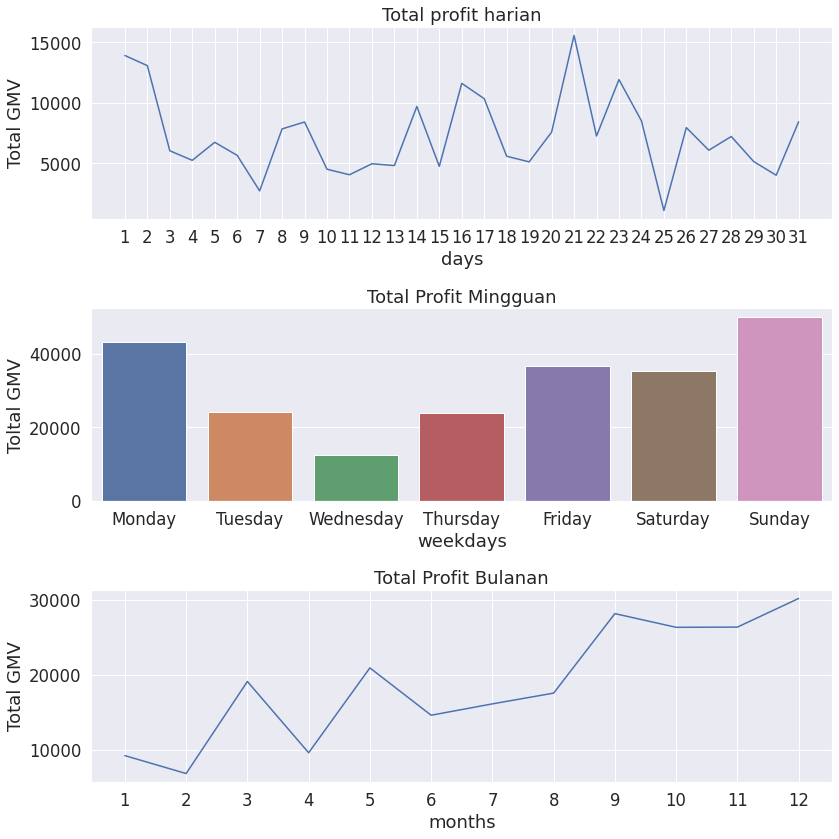

In [20]:
#dayli 
profit_dayli = df.groupby("days",as_index=False)["Profit"].sum()

#mingguan
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
profit_weekdays = df.groupby("weekdays",as_index=False)["Profit"].sum()

#bulanan
profit_months = df.groupby("months",as_index=False)["Profit"].sum()


#visualisasi
plt.figure(figsize=(12,12))
plt.subplot(311)
sns.lineplot(data=profit_dayli,x="days",y="Profit").set_title("Total profit harian")
plt.xticks([i for i in np.arange(1,32)])
plt.ylabel("Total GMV")

plt.subplot(312)
sns.barplot(data=profit_weekdays,x="weekdays",y="Profit",order=order).set_title("Total Profit Mingguan")
plt.ylabel("Toltal GMV")

plt.subplot(313)
sns.lineplot(data=profit_months,x="months",y="Profit").set_title("Total Profit Bulanan")
plt.xticks([i for i in np.arange(1,13)])
plt.ylabel("Total GMV")

plt.tight_layout()
plt.show()

1.Profit mengalamin penurunan di 7 hari pertama pada awal bulan dan meningkat dari tanggal 8 hingga tanggal 21 dan mengalami trend turun pada akhir bulan. <br>
2.jika diperhatikan dari hari, profit cukup bagus pada hari minggu dan senin. <br>
3.trend profit meningkat di bulan 9-12 <br>
jika diperhatikan bahwa terdapat kesamaan pola antara jumlah transaksi,GMV dan profit, jadi dengan besarnya jumlah transaksi yang terjadi makan GMV dan profit akan semakin besar

# Advance Nomor 2

Hitunglah monthly retention dari kegiatan transaksi yang terjadi di dalam platform e-commerce. (Poin 10)
Catatan: Monthly retention dihitung berdasarkan jumlah customer yang kembali 

In [21]:
#analisis rentention
df_ret = df.copy()

import datetime as dt
# A function that will parse the date Time based cohort:  1 day of month
def get_month(x): return dt.datetime(x.year, x.month, 1) 

# Create transaction_date column based on month and store in TransactionMonth
df_ret['TransactionMonth'] = df_ret['Order Date'].apply(get_month) 

# Grouping by customer_id and select the InvoiceMonth value
grouping = df_ret.groupby('Customer ID')['TransactionMonth'] 

# Assigning a minimum InvoiceMonth value to the dataset
df_ret['CohortMonth'] = grouping.transform('min')


df_ret.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,GMV,months,days,weekdays,TransactionMonth,CohortMonth
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,523.920000,11,8,Tuesday,2016-11-01,2015-10-01
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2195.820000,11,8,Tuesday,2016-11-01,2015-10-01
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,29.240000,6,12,Sunday,2016-06-01,2016-06-01
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2633.338125,10,11,Sunday,2015-10-01,2015-10-01
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,35.788800,10,11,Sunday,2015-10-01,2015-10-01


In [22]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Getting the integers for date parts from the `InvoiceDay` column
transcation_year, transaction_month, _ = get_date_int(df_ret, 'TransactionMonth')

# Getting the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(df_ret, 'CohortMonth')


#  Get the  difference in years
years_diff = transcation_year - cohort_year

# Calculate difference in months
months_diff = transaction_month - cohort_month

df_ret['CohortIndex'] = years_diff * 12 + months_diff  + 1 

df_ret.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,GMV,months,days,weekdays,TransactionMonth,CohortMonth,CohortIndex
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,523.920000,11,8,Tuesday,2016-11-01,2015-10-01,14
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2195.820000,11,8,Tuesday,2016-11-01,2015-10-01,14
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,29.240000,6,12,Sunday,2016-06-01,2016-06-01,1
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2633.338125,10,11,Sunday,2015-10-01,2015-10-01,1
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,35.788800,10,11,Sunday,2015-10-01,2015-10-01,1


In [23]:
# Counting daily active user from each chort
grouping = df_ret.groupby(['CohortMonth', 'CohortIndex'])



# Counting number of unique customer Id's falling in each group of CohortMonth and CohortIndex
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()


 # Assigning column names to the dataframe created above
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'Customer ID')

# Printing top 5 rows of Dataframe
cohort_data.head()

,CohortMonth,CohortIndex,Customer ID
0,2014-01-01,1,27
1,2014-01-01,4,2
2,2014-01-01,5,2
3,2014-01-01,7,2
4,2014-01-01,8,1


In [24]:
cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes, axis=0)

# Coverting the retention rate into percentage and Rounding off.
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48
CohortMonth,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,100.0,NaN,NaN,7.4,7.4,NaN,7.4,3.7,3.7,11.1,18.5,11.1,7.4,NaN,11.1,7.4,3.7,11.1,7.4,7.4,11.1,NaN,18.5,14.8,7.4,3.7,14.8,7.4,11.1,11.1,3.7,NaN,25.9,3.7,18.5,14.8,11.1,3.7,14.8,11.1,18.5,11.1,3.7,3.7,22.2,33.3,22.2,14.8
2014-02-01,100.0,5.9,5.9,NaN,NaN,11.8,5.9,17.6,5.9,5.9,23.5,NaN,NaN,5.9,5.9,5.9,11.8,5.9,NaN,23.5,NaN,11.8,11.8,NaN,5.9,5.9,5.9,11.8,NaN,11.8,17.6,17.6,5.9,5.9,17.6,11.8,5.9,23.5,11.8,5.9,23.5,NaN,5.9,23.5,5.9,29.4,NaN,NaN
2014-03-01,100.0,5.9,2.0,13.7,9.8,NaN,9.8,3.9,7.8,7.8,2.0,2.0,7.8,3.9,7.8,2.0,2.0,5.9,3.9,13.7,19.6,15.7,2.0,2.0,7.8,11.8,11.8,11.8,7.8,7.8,13.7,7.8,13.7,5.9,3.9,3.9,9.8,13.7,11.8,13.7,9.8,11.8,25.5,3.9,21.6,17.6,NaN,NaN
2014-04-01,100.0,6.8,NaN,6.8,4.5,6.8,6.8,13.6,11.4,2.3,2.3,6.8,18.2,13.6,4.5,4.5,6.8,11.4,4.5,20.5,13.6,4.5,2.3,9.1,9.1,6.8,15.9,13.6,4.5,20.5,9.1,15.9,15.9,6.8,4.5,18.2,4.5,11.4,11.4,11.4,13.6,15.9,13.6,13.6,20.5,NaN,NaN,NaN
2014-05-01,100.0,10.2,6.1,4.1,16.3,6.1,16.3,16.3,6.1,4.1,4.1,12.2,2.0,8.2,4.1,6.1,10.2,8.2,16.3,12.2,8.2,4.1,4.1,14.3,12.2,8.2,4.1,4.1,16.3,6.1,20.4,20.4,4.1,4.1,4.1,6.1,12.2,12.2,10.2,8.2,30.6,16.3,22.4,16.3,NaN,NaN,NaN,NaN
2014-06-01,100.0,4.9,NaN,7.3,4.9,14.6,9.8,2.4,9.8,12.2,7.3,9.8,7.3,12.2,4.9,4.9,9.8,31.7,12.2,7.3,2.4,12.2,9.8,9.8,2.4,7.3,2.4,19.5,12.2,12.2,26.8,7.3,7.3,4.9,14.6,9.8,14.6,9.8,4.9,22.0,7.3,29.3,22.0,NaN,NaN,NaN,NaN,NaN
2014-07-01,100.0,8.8,11.8,NaN,14.7,20.6,8.8,2.9,17.6,2.9,8.8,8.8,8.8,NaN,14.7,5.9,11.8,14.7,2.9,2.9,5.9,2.9,11.8,5.9,8.8,23.5,11.8,14.7,20.6,20.6,5.9,14.7,8.8,5.9,14.7,11.8,8.8,11.8,17.6,8.8,23.5,17.6,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-01,100.0,11.1,4.4,13.3,6.7,4.4,6.7,4.4,8.9,2.2,8.9,17.8,4.4,13.3,4.4,4.4,20.0,4.4,2.2,4.4,6.7,8.9,15.6,8.9,15.6,26.7,8.9,24.4,17.8,4.4,8.9,2.2,15.6,8.9,11.1,15.6,13.3,17.8,26.7,17.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-01,100.0,6.2,10.8,12.3,1.5,4.6,7.7,10.8,9.2,1.5,6.2,6.2,15.4,6.2,10.8,16.9,3.1,1.5,13.8,7.7,9.2,7.7,9.2,4.6,9.2,4.6,13.8,18.5,1.5,3.1,9.2,10.8,9.2,12.3,12.3,12.3,18.5,10.8,16.9,16.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
retention.index = retention.index.strftime('%Y-%m')
retention.index

Index(['2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06',
       '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
       '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
       '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
       '2017-09', '2017-10', '2017-11'],
      dtype='object', name='CohortMonth')

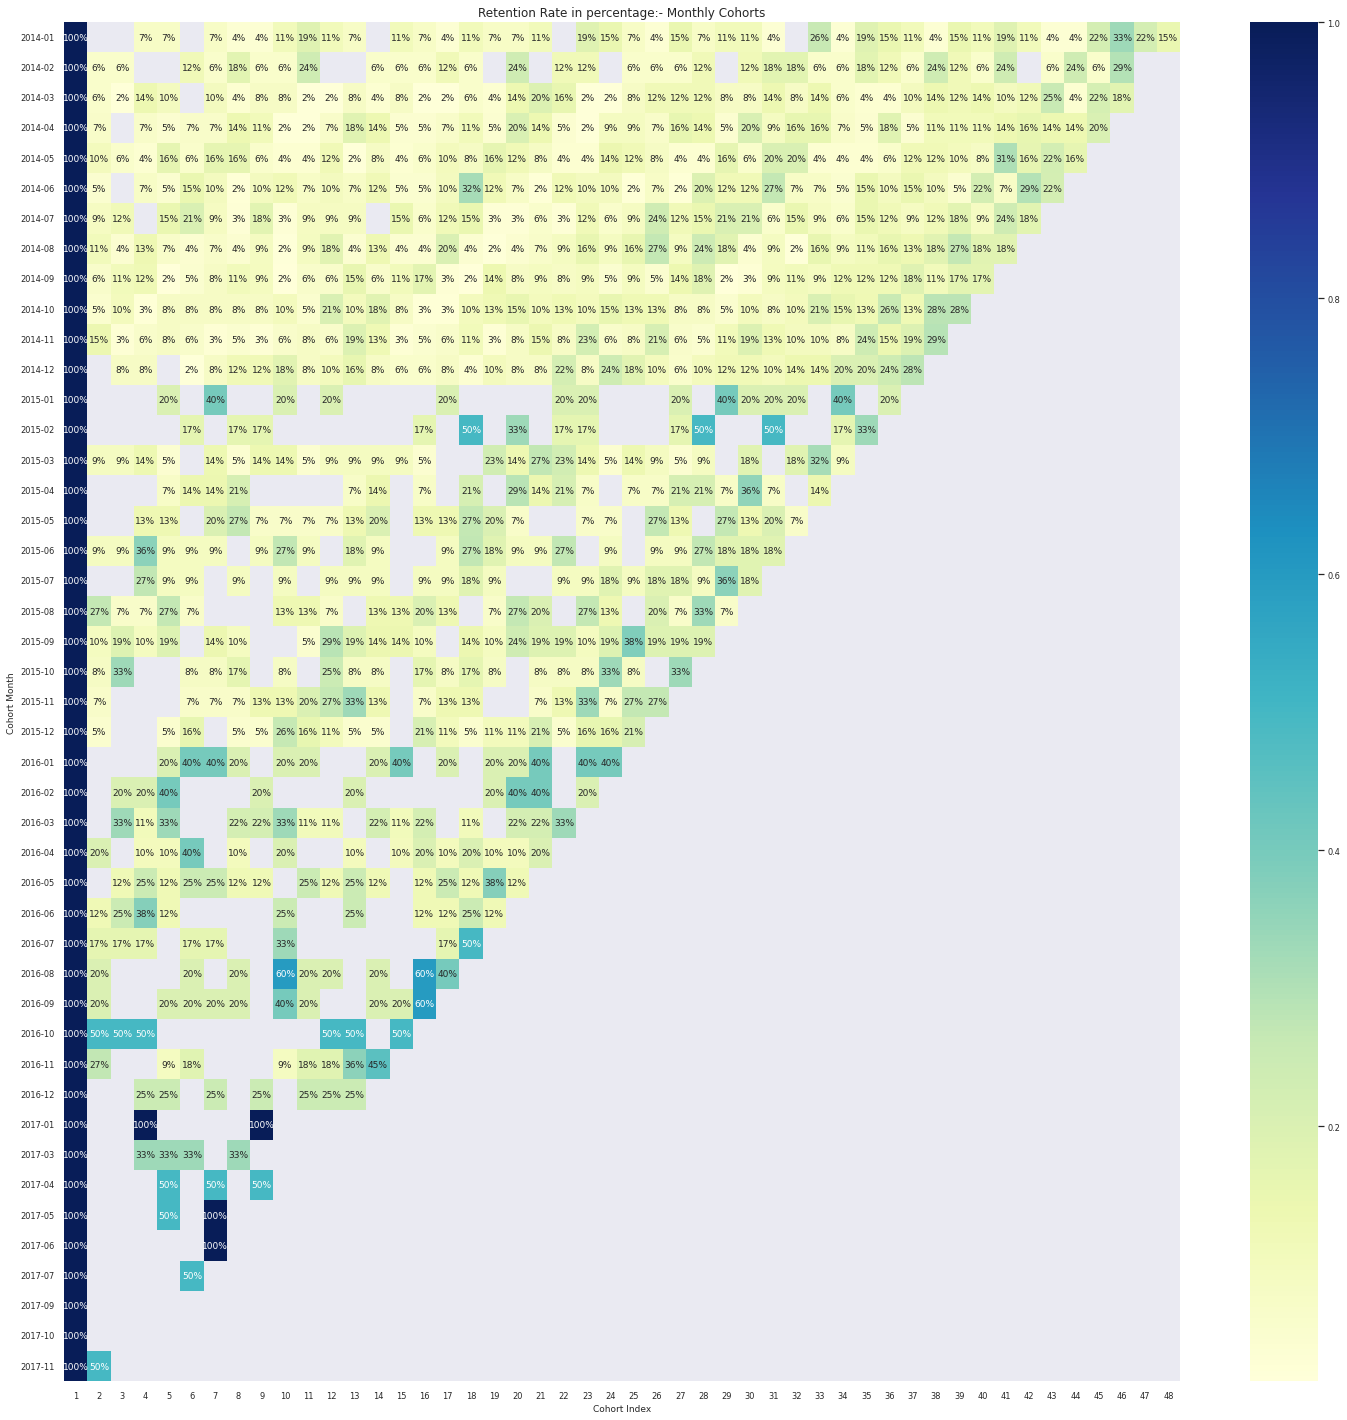

In [26]:
# Initialize the figure
plt.figure(figsize=(25,25))
sns.set(font_scale=0.75)

# Adding a title
plt.title('Retention Rate in percentage:- Monthly Cohorts', fontsize = 12)

# Creating the seaborn based heatmap
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()

dari retention rate terlihat bahwa rentang 2-3 bulan setelah cistomer berbelanja maka terdapat kemungkinan besar customer akan kembali berbelanja, tentunya ini bisa menjadi landasan bisnis bahwa ketika 2-3 bulan setelah customer berbelanja di platform maka bisa dilakukan rekomendasi produk untuk menarik kembali minat customer untuk berbelanja

# Nomor 3
Identifikasi produk-produk apa saja yang membawa profit terbesar dalam 3 bulan terakhir (Poin 5)


In [27]:
product_3m = df[(df['Order Date']>='2017-10-01 00:00:00')&(df['Order Date']<='2017-12-30 00:00:00')].copy()

In [28]:
df.groupby("Product Name")["Profit"].sum().nlargest()

Product Name
Canon imageCLASS 2200 Advanced Copier                         18479.9472
Hewlett Packard LaserJet 3310 Copier                           6743.8876
Ativa V4110MDD Micro-Cut Shredder                              3772.9461
3D Systems Cube Printer, 2nd Generation, Magenta               3717.9714
Plantronics Savi W720 Multi-Device Wireless Headset System     3696.2820
Name: Profit, dtype: float64

jadi profit terbesar dalam 3 bulana terakhir adalah "Canon imageCLASS 2200 Advanced Copier"

# Nomor 4

## Forecasing Jumlah Pengunjung Harian

<AxesSubplot:>

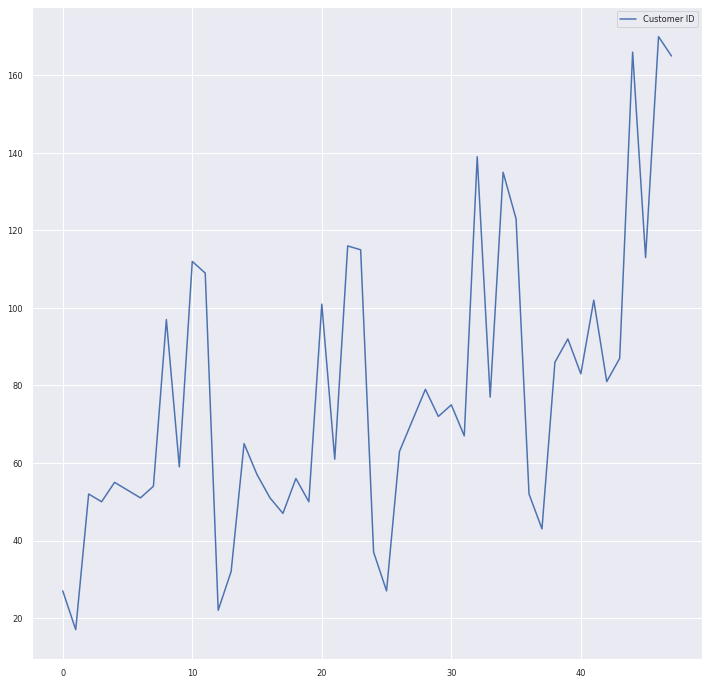

In [70]:
df["monht_year"] = df['Order Date'].dt.to_period('M')
df.groupby(["monht_year"],as_index=False).agg({'Customer ID':lambda x: x.nunique()}).plot(figsize=(12,12))

terdapat plot seasonal jumlah pengunjung mengalami peningkatan, berkisar dibulan 9-10. dengan melakukan pendekatan harian, seasonal period berkisar 250-270 hari

In [30]:
df_customer = df.groupby(["Order Date"],as_index=False).agg({'Customer ID':lambda x: x.nunique()})
df_customer = df_customer[(df_customer["Order Date"]>="2016-01-01 00:00:00")]
df_customer.shape

(617, 2)

In [31]:
#data forecasting
cust_forecast = df_customer.set_index("Order Date")
cust_forecast.columns = ["Jumlah Pengunjung"]
cust_forecast.index = pd.PeriodIndex(cust_forecast.index, freq = 'D')
cust_forecast.head()

,Jumlah Pengunjung
Order Date,
2016-01-02,1
2016-01-03,1
2016-01-04,2
2016-01-05,1
2016-01-07,1


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Jumlah Pengunjung'>)

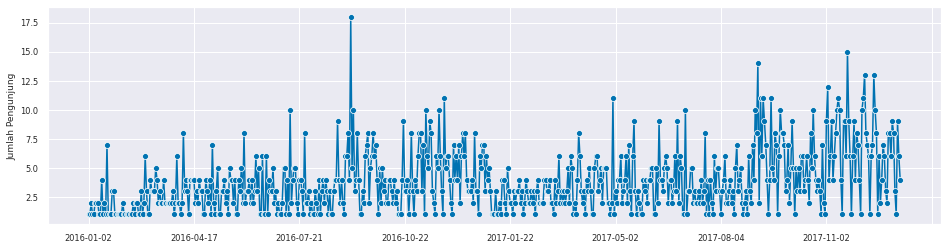

In [32]:
plot_series(cust_forecast["Jumlah Pengunjung"])

<AxesSubplot:>

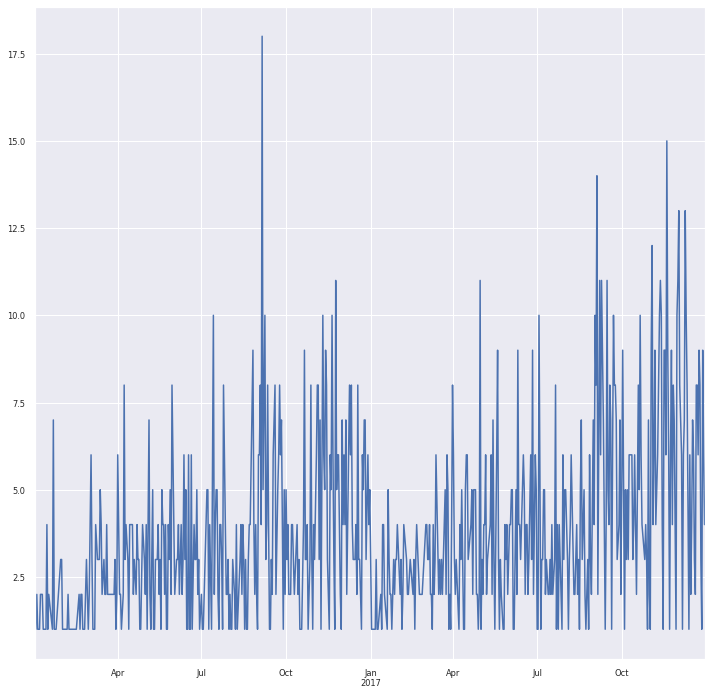

In [33]:
cust_forecast["Jumlah Pengunjung"].plot(figsize=(12,12))

In [34]:
#membuat function
def test_stationarity(ts,window=10,**kwargs):
    #membuat dataframe untuk plotingan
    plot_df = pd.DataFrame(ts)
    plot_df["rolling_mean"] = ts.rolling(window).mean()
    plot_df['rolling_std'] = ts.rolling(window).std()
    #hitung test augmented dicky-fuller
    p_val = adfuller(ts)[1]
    ax = plot_df.plot(**kwargs)
    ax.set_title(f"Dicky-Fuller p-value :{p_val:.3f}")

Jumlah Pengunjung    None
dtype: object

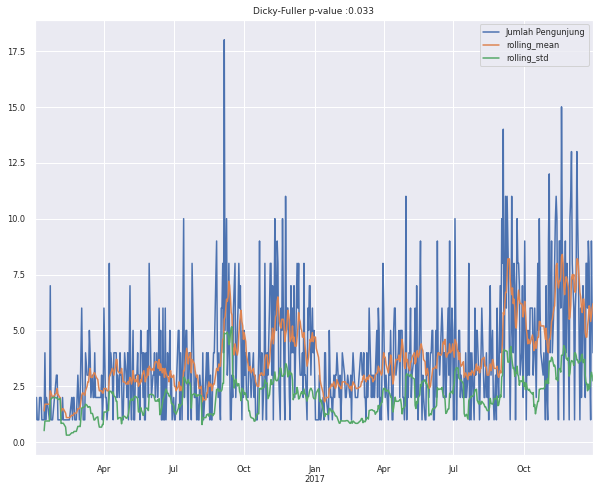

In [35]:
cust_forecast.apply(test_stationarity,figsize=(10, 8))

In [36]:
# Do train-test split
y_train, y_test = temporal_train_test_split(cust_forecast["Jumlah Pengunjung"], test_size=29)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Jumlah Pengunjung'>)

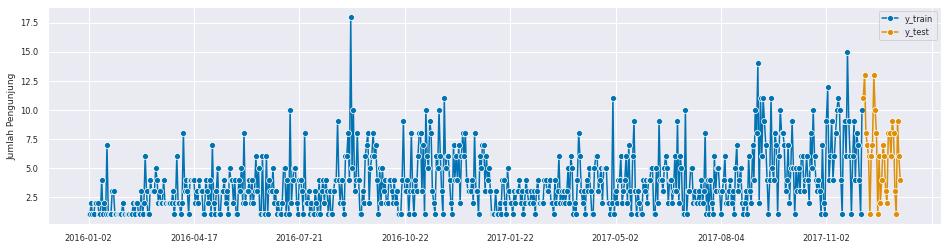

In [37]:
# check the time series after splitting
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [38]:
#specific data points
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [39]:
#Exponential Smoothing
# define ets forecaster model
ets_forecaster = ExponentialSmoothing(trend=None, seasonal='multiplicative', sp=250)

In [40]:
# fit forecaster to train data
ets_forecaster.fit(y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


ExponentialSmoothing(seasonal='multiplicative', sp=250)

In [41]:
# do prediction based on forecast horizon we already defined
y_pred_ets = ets_forecaster.predict(fh=fh)

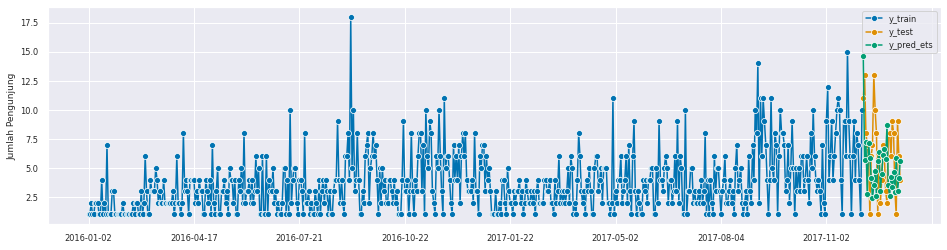

In [42]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_ets, labels=["y_train", "y_test", "y_pred_ets"]);

In [43]:
mean_absolute_percentage_error(y_test, y_pred_ets) * 100

97.09652995015767

In [44]:
#AutoETS
# define auto ets forecaster model
auto_ets_forecaster = AutoETS(auto=True, sp=250)

In [45]:
# fit forecaster to train data
auto_ets_forecaster.fit(y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

AutoETS(auto=True, sp=250)

In [46]:
# do prediction based on forecast horizon we already defined
y_pred_auto_ets = auto_ets_forecaster.predict(fh=fh)

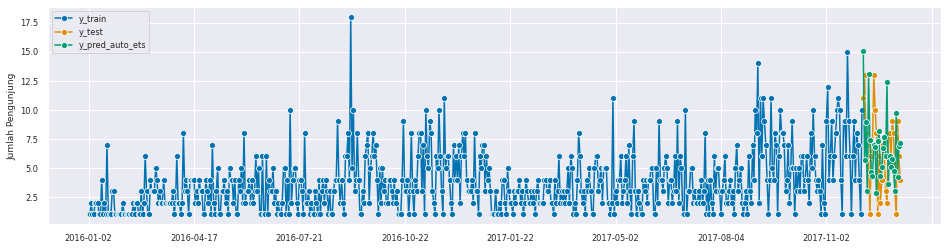

In [47]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_auto_ets, labels=["y_train", "y_test", "y_pred_auto_ets"]);

In [48]:
mean_absolute_percentage_error(y_test, y_pred_auto_ets) * 100

130.31968900942155

dari hasil model terlihat nilai MAPE terkecil adalah model ets sebesar 97.09652995015767

## Forecasting Jumlah Transaksi

<AxesSubplot:>

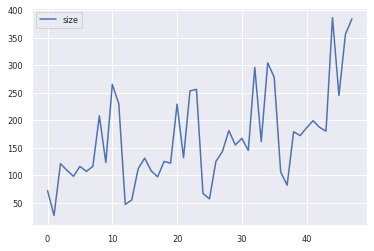

In [71]:
df.groupby(["monht_year"],as_index=False)["Order ID"].size().plot()

terlihat seasonal dari jumlah transaksi sama dengan seasonal jumlah pengunjung, sehingga dapat dikatan bahwa korelasi antara jumlah pengunjung berbanding positif dengan jumlah transaksi, dengan pendekatan yang sama pendekatan seasonal harian berkisar 250-270

In [81]:
df_jml_trx = df.groupby(["Order Date"],as_index=False)['Order ID'].size()
df_jml_trx = df_jml_trx[(df_jml_trx["Order Date"]>="2016-01-01 00:00:00")]
df_jml_trx.shape

(617, 2)

In [82]:
#data forecasting
trx_forecast = df_jml_trx.set_index("Order Date")
trx_forecast.columns = ["Jumlah trx"]
trx_forecast.index = pd.PeriodIndex(trx_forecast.index, freq = 'D')
trx_forecast.head()

,Jumlah trx
Order Date,
2016-01-02,2
2016-01-03,1
2016-01-04,3
2016-01-05,3
2016-01-07,1


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Jumlah trx'>)

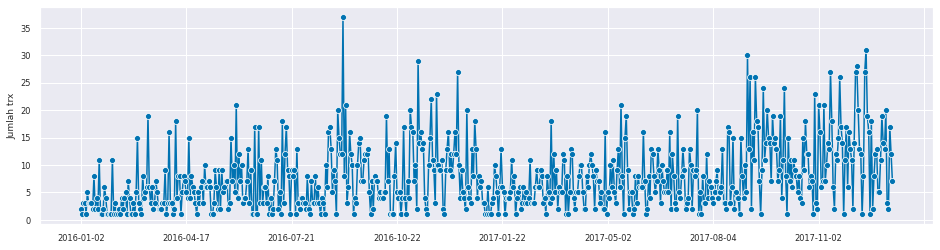

In [83]:
plot_series(trx_forecast["Jumlah trx"])

Jumlah trx    None
dtype: object

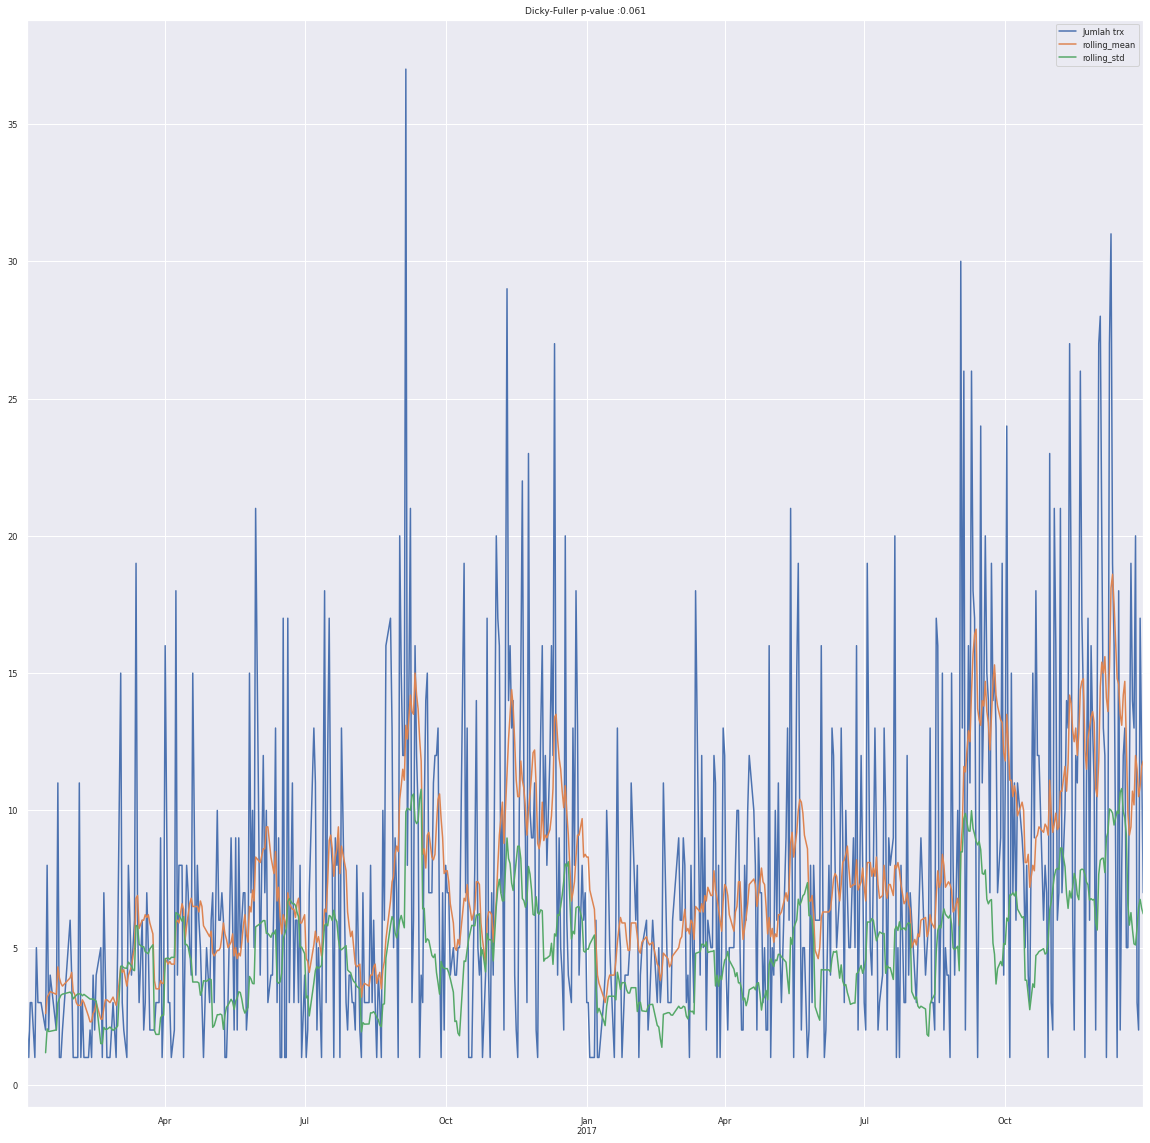

In [84]:
trx_forecast.apply(test_stationarity,figsize=(20,20))

In [85]:
# Do train-test split
y_train, y_test = temporal_train_test_split(trx_forecast["Jumlah trx"], test_size=29)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Jumlah trx'>)

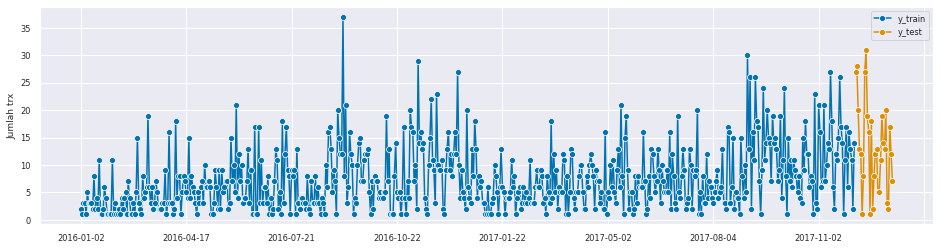

In [86]:
# check the time series after splitting
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [87]:
#specific data points
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [88]:
#Exponential Smoothing
# define ets forecaster model
ets_forecaster = ExponentialSmoothing(trend=None, seasonal='multiplicative', sp=250)

In [89]:
# fit forecaster to train data
ets_forecaster.fit(y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


ExponentialSmoothing(seasonal='multiplicative', sp=250)

In [90]:
# do prediction based on forecast horizon we already defined
y_pred_ets = ets_forecaster.predict(fh=fh)

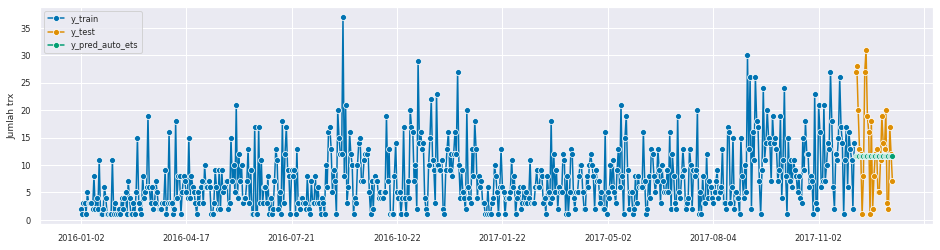

In [91]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_auto_ets, labels=["y_train", "y_test", "y_pred_auto_ets"]);

In [92]:
mean_absolute_percentage_error(y_test, y_pred_ets) * 100

201.4783482770654

In [93]:
#AutoETS
# define auto ets forecaster model
auto_ets_forecaster = AutoETS(auto=True, sp=250)

In [94]:
# fit forecaster to train data
auto_ets_forecaster.fit(y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: 

AutoETS(auto=True, sp=250)

In [95]:
# do prediction based on forecast horizon we already defined
y_pred_auto_ets = auto_ets_forecaster.predict(fh=fh)

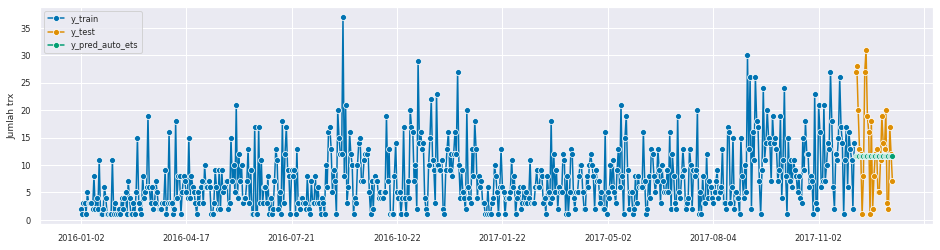

In [96]:
# plot the forecast result
plot_series(y_train, y_test, y_pred_auto_ets, labels=["y_train", "y_test", "y_pred_auto_ets"]);

In [97]:
mean_absolute_percentage_error(y_test, y_pred_auto_ets) * 100

149.51856443379285

dari hasil model time series, model auto ets memiliki mape terkecil sehingga model auto ets lebih baik dari model ets

## Rekomendasi

1.Dilihat dari pola transaksi bahwa pertengahan bulan adalah waktu yang bagus untuk melakukan campanye marketing untuk jualan karena pada rentang waktu tersebut jumlah customer cukup banyak dan jumlah transaksi cukup banyak, dengan melakukan flash sale, diskon untuk target tertentu yang berupa customer loyal untuk membeli produk dengan harga mahal untuk mendatangkan profit.
2.target hari untuk jual dengan harga diskon yaitu senin dan minggu karena frekuensi customer dan transaksi cukup besar dan juga profit cukup besar pada hari tersebut, sehingga cocok digunakan untuk serangan diskon dan flash sale untuk produk yang kurang laku terjual. <br>
3.pada bulan 9-11 sebaiknya perlu diperbanyak stok yang laku terjual seperti kebutuhan pokok, kebutuhan sekolah dll. 